In [120]:
# 1-) import required modules, libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

In [121]:
# 2-) read files

cab = pd.read_csv("./Cab_Data.csv", low_memory=False)
city = pd.read_csv("./City.csv", low_memory=False)
customer = pd.read_csv("./Customer_ID.csv", low_memory=False)
transaction = pd.read_csv("./Transaction_ID.csv", low_memory=False)
holidays = pd.read_csv("./US_Holiday_Dates.csv", low_memory=False)

cab.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [122]:
# 3-) edit cab

# Add new features
cab["Profit"] = cab["Price Charged"] - cab["Cost of Trip"]
cab["Profit_per_km"] = cab["Profit"] / cab["KM Travelled"]

# Merge transaction and customer on cab
cab = pd.merge(cab, transaction, on="Transaction ID", how="left")
cab = pd.merge(cab, customer, on="Customer ID", how="left")

# Yellow Cab    274681, Pink Cab       84711
company = {} # Company names as key, transactions grouped by company as values 
for label,group in cab.groupby("Company"):
    company[label] = group

cab.head() #359392 row, all unique

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit,Profit_per_km,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635,57.315,1.882266,29290,Card,Male,28,10813
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854,23.666,0.826904,27703,Card,Male,27,9237
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632,27.568,3.049558,28712,Cash,Male,53,11242
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602,25.798,0.777751,28020,Cash,Male,23,23327
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776,16.844,1.929439,27182,Card,Male,33,8536


In [123]:
# Edit transactions

# Merge certain cab columns on transaction
transaction = pd.merge(transaction, cab[["Transaction ID","Company"]], on="Transaction ID", how="left")
transaction.head() # 440098 unique transaction, 49171 customer

,Transaction ID,Customer ID,Payment_Mode,Company
0,10000011,29290,Card,Pink Cab
1,10000012,27703,Card,Pink Cab
2,10000013,28712,Cash,Pink Cab
3,10000014,28020,Cash,Pink Cab
4,10000015,27182,Card,Pink Cab


In [124]:
# Edit customer 

# Merge  transaction on customer
customer = pd.merge(customer, transaction, on="Customer ID", how="left")
customer = customer.drop("Transaction ID",axis=1)

# Get the count of every cab for every customer
pink_count = customer[customer['Company'] == 'Pink Cab'].groupby('Customer ID').size()
yellow_count = customer[customer['Company'] == 'Yellow Cab'].groupby('Customer ID').size()

# Add every count of company for every customer
customer['Pink Cab'] = customer['Customer ID'].map(pink_count).fillna(0).astype(int)
customer['Yellow Cab'] = customer['Customer ID'].map(yellow_count).fillna(0).astype(int)

# Do the same for Payment_Mode
cash_count = customer[customer['Payment_Mode'] == 'Cash'].groupby('Customer ID').size()
card_count = customer[customer['Payment_Mode'] == 'Card'].groupby('Customer ID').size()

customer['Cash'] = customer['Customer ID'].map(cash_count).fillna(0).astype(int)
customer['Card'] = customer['Customer ID'].map(card_count).fillna(0).astype(int)

# Drop unnecessary columns
customer.drop(columns=['Payment_Mode', "Company"],axis=1, inplace=True)

# Delete duplicates
customer.drop_duplicates(subset=["Customer ID"], inplace=True)

customer.head()

,Customer ID,Gender,Age,Income (USD/Month),Pink Cab,Yellow Cab,Cash,Card
0,29290,Male,28,10813,1,2,1,2
3,27703,Male,27,9237,2,2,1,3
7,28712,Male,53,11242,1,3,2,2
11,28020,Male,23,23327,3,1,3,1
15,27182,Male,33,8536,1,3,1,3


In [125]:
# Create a folder to save charts
if not os.path.exists("graphs"):
    os.makedirs("graphs")
    print("images klasörü olustu")

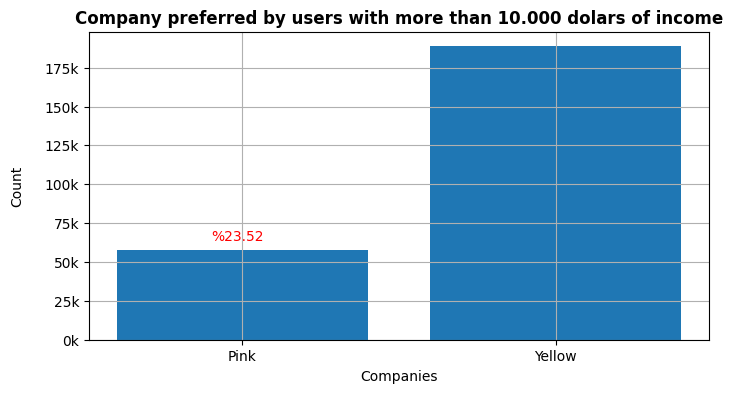

In [126]:
# Analyze which company preferred by users with more than 10.000 dolars of income

pink_sum = (customer[customer["Income (USD/Month)"] > 10000])["Pink Cab"].sum()
yellow_sum = (customer[customer["Income (USD/Month)"] > 10000])["Yellow Cab"].sum()

fig,ax = plt.subplots(figsize=(8,4))
ax.bar(["Pink", "Yellow"], [pink_sum, yellow_sum])
ax.set_title("Company preferred by users with more than 10.000 dolars of income", fontweight="bold")
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
ax.text(-0.1,pink_sum*1.1,"%{}".format(np.round((pink_sum/(pink_sum+yellow_sum)*100),2)), color='red')
ax.set_xlabel("Companies")
ax.set_ylabel("Count", labelpad=15)
ax.grid()
fig.savefig("./graphs/preferred_companies.png")
plt.show()

{'Female': 37480, 'Male': 47231}
{'Female': 116000, 'Male': 158681}


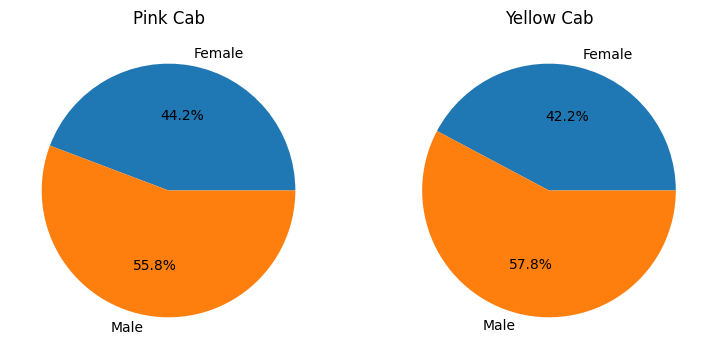

In [160]:
# Gender analysis for each company

gender_nums_pink = {}
for label,group in company["Pink Cab"].groupby("Gender"):
    gender_nums_pink[label] = group.shape[0]
print(gender_nums_pink)

gender_nums_yellow = {}
for label,group in company["Yellow Cab"].groupby("Gender"):
    gender_nums_yellow[label] = group.shape[0]
print(gender_nums_yellow)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,5))

ax1.pie([gender_nums_pink["Female"], gender_nums_pink["Male"]], labels=["Female", "Male"], autopct='%1.1f%%')
ax1.set_title("Pink Cab")
ax2.pie([gender_nums_yellow["Female"], gender_nums_yellow["Male"]], labels=["Female", "Male"], autopct='%1.1f%%')
ax2.set_title("Yellow Cab")
fig.savefig("./graphs/gender_of_customers.png")

{42371: 4809.42, 42372: 10620.58, 42373: 428.59, 42374: 745.36, 42375: 2336.98, 42376: 1254.6, 42377: 2257.64, 42378: 6684.57, 42379: 7112.42, 42380: 842.85, 42381: 1306.53, 42382: 660.12, 42383: 1090.72, 42384: 1122.69, 42385: 3109.71, 42386: 4011.77, 42387: 1130.53, 42388: 321.79, 42389: 544.01, 42390: 1165.62, 42391: 1185.98, 42392: 3979.17, 42393: 3304.22, 42394: 1035.14, 42395: 884.59, 42396: 633.22, 42397: 670.78, 42398: 397.66, 42399: 6140.86, 42400: 4164.74, 42401: 253.31, 42402: 1263.38, 42403: 1087.8, 42404: 1491.15, 42405: 1475.64, 42406: 6844.58, 42407: 8510.26, 42408: 1244.57, 42409: 1306.45, 42410: 1043.13, 42411: 1883.37, 42412: 1767.41, 42413: 7733.49, 42414: 6086.33, 42415: 1135.42, 42416: 464.35, 42417: 1697.39, 42418: 1891.25, 42419: 1676.95, 42420: 7391.2, 42421: 6087.14, 42422: 2227.65, 42423: 1436.89, 42424: 1336.71, 42425: 2042.06, 42426: 1425.31, 42427: 7456.95, 42428: 7642.34, 42429: 1573.06, 42430: 1162.06, 42431: 1418.47, 42432: 2137.23, 42433: 1840.51, 42434

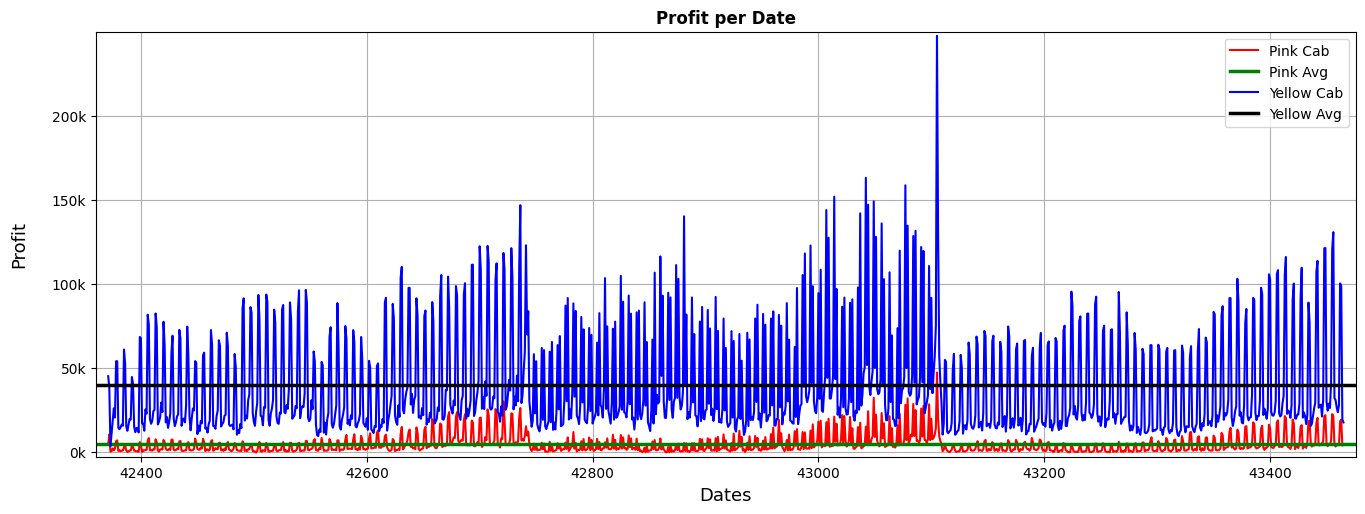

In [193]:
# Profit per Date for each company (with avarages)

pink_dates = {}
for label,group in company["Pink Cab"].groupby("Date of Travel"):
    pink_dates[label] = round(sum(group["Profit"]),2)
print(pink_dates)

yellow_dates = {}
for label,group in company["Yellow Cab"].groupby("Date of Travel"):
    yellow_dates[label] = round(sum(group["Profit"]),2)
print(yellow_dates)


pink_df = pd.DataFrame({"Date" : pink_dates.keys(), "Profit" : pink_dates.values()})
yellow_df = pd.DataFrame({"Date" : yellow_dates.keys(), "Profit" : yellow_dates.values()})
avg_pink = pink_df["Profit"].mean()
avg_yellow = yellow_df["Profit"].mean()

fig,ax = plt.subplots(figsize = (14,5))
ax.plot(pink_dates.keys(), pink_dates.values(), color="red", label="Pink Cab")
ax.axhline(y=avg_pink, color='green', linestyle='-', label='Pink Avg', lw=2.5)

ax.plot(yellow_dates.keys(), yellow_dates.values(), color="blue", label="Yellow Cab")
ax.axhline(y=avg_yellow, color='black', linestyle='-', label='Yellow Avg', lw=2.5)
ax.set_xlabel("Dates", fontsize=13)
ax.set_ylabel("Profit", fontsize=13, labelpad=17)

plt.legend()
plt.grid()
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
plt.margins(0.01)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(left=0.07)
plt.subplots_adjust(right=0.97)

plt.subplots_adjust(bottom=0.1)
plt.title("Profit per Date", fontweight="bold")
plt.savefig("./graphs/profits_of_cabs_per_date.png")
plt.show()

5307328.32
44020373.17


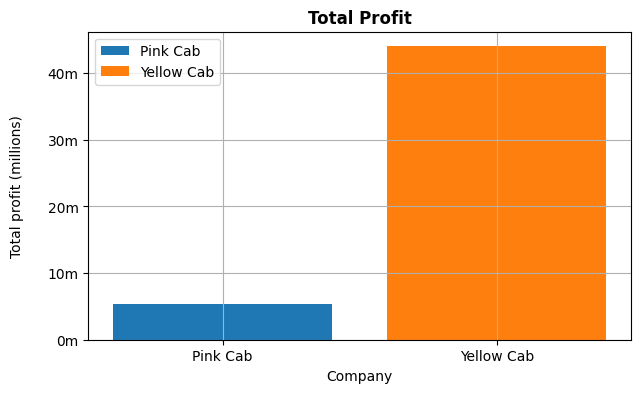

In [129]:
# Total profit of each company

pink_total = round(sum(company["Pink Cab"]["Profit"]),2)
yellow_total = round(sum(company["Yellow Cab"]["Profit"]),2)
print(pink_total)
print(yellow_total)

fig, ax = plt.subplots(figsize=(7,4))
plt.bar("Pink Cab", pink_total, label="Pink Cab")
plt.bar("Yellow Cab", yellow_total, label="Yellow Cab")
plt.legend()
def millions_formatter(x, pos):
    return f'{int(x/1000000)}m'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

ax.set_xlabel("Company")
ax.set_ylabel("Total profit (millions)", labelpad=17)
plt.title("Total Profit", fontweight="bold")
plt.grid()
plt.savefig("./graphs/total_profit_per_cab.png")
plt.show()

In [130]:
# Edit city

city_profit = {}
for label,group in cab.groupby("City"):
    city_profit[label] = group

city_profit_num = {}
for label in city_profit.keys():
    city_profit_num[label] = {}
    for label2,group in city_profit[label].groupby("Company"):
        
        city_profit_num[label][label2] = round(sum(group["Profit"]),2)

# Edit columns
city["Population"] = city["Population"].str.replace(",","").astype(int)
city["Users"] = city["Users"].str.replace(",","").astype(int)

# Create new columns
city["Percentage(%)"] = round((city["Users"] / city["Population"]) * 100, 2)

# Total profit of each company
for key in next(iter(city_profit_num.values())).keys():
    city[key] = city['City'].map(lambda x: city_profit_num.get(x, {}).get(key, 0))
    
# Rename certain columns
city.rename(columns={"Pink Cab":"Total Profit(Pink)", "Yellow Cab":"Total Profit(Yellow)"},inplace=True)

# Create new columns
city["Profit per User"] = round((city["Total Profit(Pink)"] + city["Total Profit(Yellow)"]) / city["Users"],2)

print(city.head(10))

             City  Population   Users  Percentage(%)  Total Profit(Pink)  \
0     NEW YORK NY     8405837  302149           3.59          1511474.39   
1      CHICAGO IL     1955130  164468           8.41           318722.49   
2  LOS ANGELES CA     1595037  144132           9.04          1125732.07   
3        MIAMI FL     1339155   17675           1.32           162301.19   
4  SILICON VALLEY     1177609   27247           2.31           340250.53   
5   ORANGE COUNTY     1030185   12994           1.26           101995.83   
6    SAN DIEGO CA      959307   69995           7.30           637889.77   
7      PHOENIX AZ      943999    6133           0.65            35596.39   
8       DALLAS TX      942908   22157           2.35            24730.11   
9      ATLANTA GA      814885   24701           3.03            96050.08   

   Total Profit(Yellow)  Profit per User  
0           26451080.77            92.55  
1            3068590.93            20.60  
2            3285976.58           

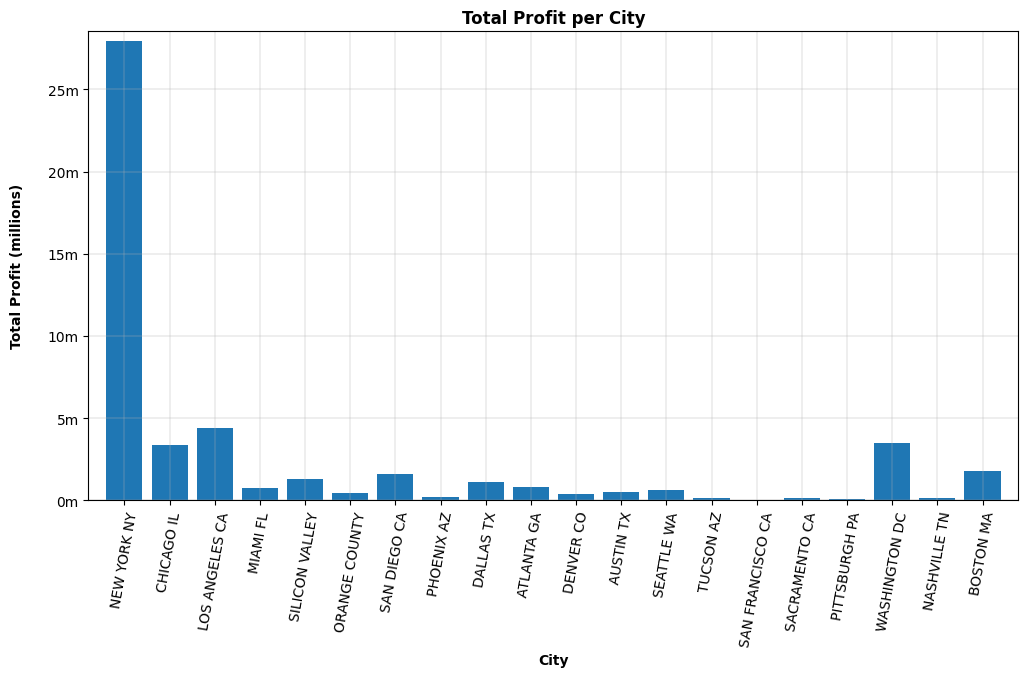

In [156]:
# Total profit per City

fig, ax = plt.subplots(figsize=(12,7))
plt.bar(city["City"], city["Total Profit(Pink)"] + city["Total Profit(Yellow)"])
plt.grid(linewidth=0.3)
plt.xticks(rotation=80)
def millions_formatter(x, pos):
    return f'{int(x/1000000)}m'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.title("Total Profit per City", fontweight="bold")
plt.xlabel("City", fontweight="bold")
plt.ylabel("Total Profit (millions)", fontweight="bold", labelpad=17)
plt.margins(0.02)
plt.subplots_adjust(bottom=0.27)
plt.subplots_adjust(top=.94)
plt.savefig("./graphs/total_profit_per_city.png")
plt.show()

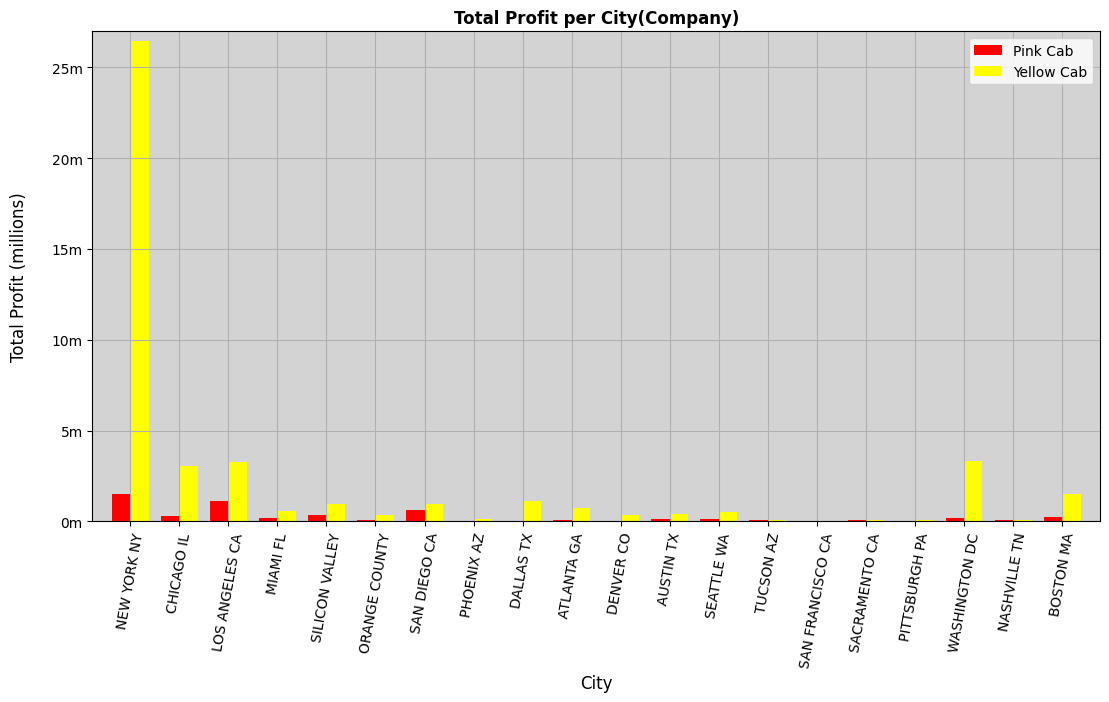

In [152]:
# Total profit per City for each company

x = np.arange(len(city["City"])) * 2
width = 0.75

fig,ax = plt.subplots(figsize=(13,7))

fig.patch.set_facecolor('white')  # Tüm figür arka plan rengi
ax.set_facecolor('lightgrey')  # Eksenlerin arka plan rengi

bar1 = ax.bar(x-width/2, city["Total Profit(Pink)"], width, label="Pink Cab", color="Red")
bar2 = ax.bar(x+width/2, city["Total Profit(Yellow)"], width, label="Yellow Cab", color="yellow")

ax.set_xticks(x)
ax.set_xticklabels(city["City"], rotation=80)
def millions_formatter(x, pos):
    return f'{int(x/1000000)}m'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
ax.legend()
plt.grid()
plt.margins(0.02)
plt.title("Total Profit per City(Company)", fontweight="bold")
plt.xlabel("City", fontsize=12)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=0.25)
plt.ylabel("Total Profit (millions)", fontsize=12, labelpad=17)
plt.savefig("./graphs/total_profit_per_city(company).png")
plt.show()

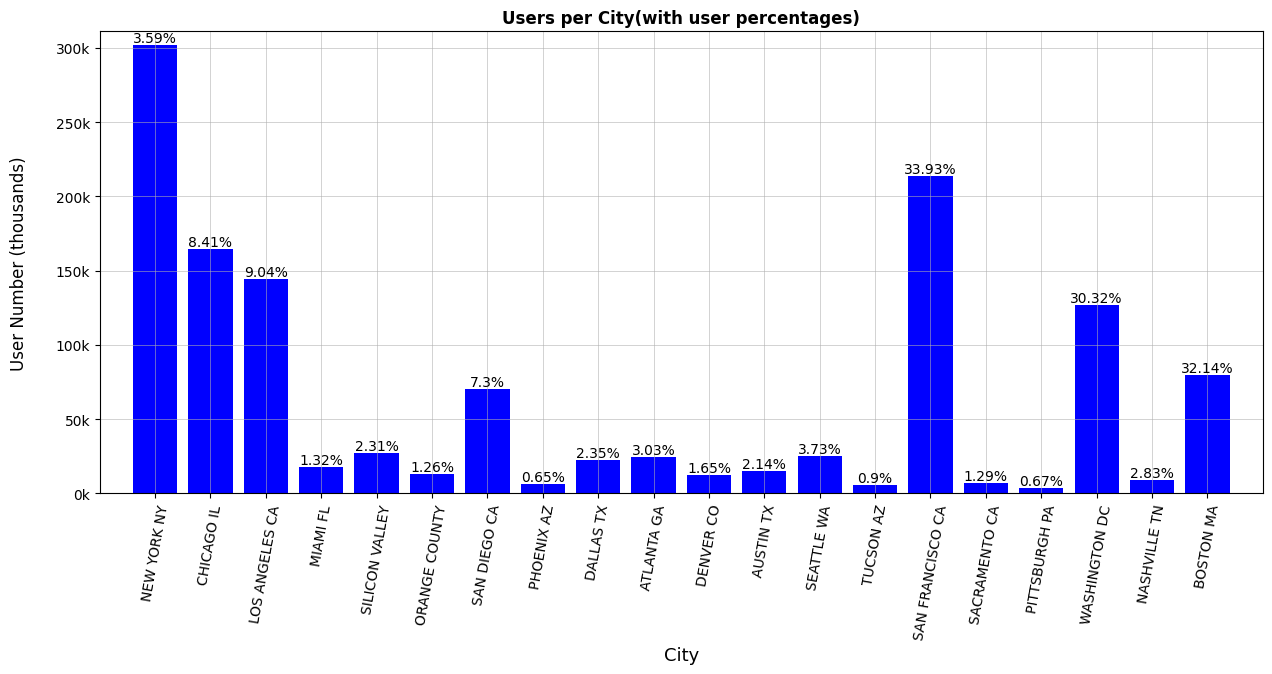

In [154]:
# Users per City with user percentages

fig, ax = plt.subplots(figsize=(15,7))

bars = ax.bar(city["City"], city["Users"], color='blue')

for bar, percentage in zip(bars, city["Percentage(%)"]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage}%', ha='center', va='bottom')
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

plt.xticks(rotation=80)
plt.grid(linewidth=0.4)
plt.title("Users per City(with user percentages)", fontweight="bold")
plt.xlabel("City", fontsize=13)
plt.ylabel("User Number (thousands)", fontsize=12, labelpad=20)
plt.margins(0.03)
plt.subplots_adjust(top=.93)
plt.subplots_adjust(bottom=0.27)
plt.savefig("./graphs/users_per_city.png")
plt.show()